# Sammensetning av alt

#### Imports

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings
from LSTM import long_short_term_memory as LSTM
from rf import rf

#### Colors

In [16]:
rsrp_colors = ['#384959', '#6A89A7', '#88BDF2', '#BDDDFC']
rsrq_colors = ['#614419', '#B37E2E', '#DB9A39', '#FFB343']
sinr_colors = ['#135E4B', '#4CB572', '#A1D8B5', '#CCDCDB']
mode_colors = ['#872323', '#C93636', '#E26666', '#F4B6B6']

In [17]:
'''
    Reading the dataset and returning two pandas DataFrames:
        The first DataFrame containing every datapoint belonging to the given campaign (if any)
        The second DataFrame containing only one column - the mode (4G or 5G)
'''
def read_dataset(filename, campaign=None, features=None):
    df = pd.read_csv(filename)
    df = df.loc[:, ~df.columns.str.match('Unnamed')]
    df = df.loc[:, ~df.columns.str.match('Timestamp')]
    df = df.replace('DC', 1)
    df = df.replace('LTE', 0)
    df = df[df['campaign'].str.contains('Driving')]

    if campaign != None:
        df = df[df['campaign'] == campaign]

    if features == None:
        features = ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ', 'campaign']
    
    df, mode = df[features], df['Mode']
    return df, mode


'''
    Returns a sequence indicating if a handover has happened when predicting 1 timestep ahead
'''
def check_handover(y, which='both' or '5g' or '4g'):
    new_y = [0]
    for i in range(len(y) - 1):
        if which == 'both':
            if y.iloc[i] == y.iloc[i + 1]:
                new_y.append(0)
            else:
                new_y.append(1)
        
        if which == '5g':
            if y.iloc[i] == 0 and y.iloc[i + 1] == 1:
                new_y.append(1)
            else:
                new_y.append(0)

        if which == '4g':
            if y.iloc[i] == 1 and y.iloc[i + 1] == 0:
                new_y.append(1)
            else:
                new_y.append(0)

    return np.array(new_y)

def check_handover_array(y, which='both' or '5g' or '4g'):
    new_y = [0]
    for i in range(len(y) - 1):
        if which == 'both':
            if y[i] == y[i + 1]:
                new_y.append(0)
            else:
                new_y.append(1)
        
        if which == '5g':
            if y[i] == 0 and y[i + 1] == 1:
                new_y.append(1)
            else:
                new_y.append(0)

        if which == '4g':
            if y[i] == 1 and y[i + 1] == 0:
                new_y.append(1)
            else:
                new_y.append(0)

    return np.array(new_y)

## LSTM-prediction of signal strength indicators

In [18]:
tf.random.set_seed(4567)
campaign='Interactivity_gaming_4G5G_TIM_Driving_Palasport_to_Via_Appia_End_No_Flight_Mode'
test_campaign = 'Ping_UNIDATA_4G5G_TIM_Driving_Palasport_to_Via_Appia_End_No_Flight_Mode'

train, mode_train = read_dataset('datasets/Op1_merged.csv', campaign=campaign)
test, mode_test = read_dataset('datasets/Op1_merged.csv', campaign=test_campaign)

results = {}
target_features = ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']
feature_selection = [['RSRP'], ['SINR'], ['RSRQ'], 
                     ['RSRP', 'SINR'], ['RSRP', 'RSRQ'], ['SINR', 'RSRQ'], ['RSRP', 'SINR', 'RSRQ'],
                     ['SSS_RSRP'], ['SSS_SINR'], ['SSS_RSRQ'],
                     ['SSS_RSRP', 'SSS_SINR'], ['SSS_RSRP', 'SSS_RSRQ'], ['SSS_SINR', 'SSS_RSRQ'], ['SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ'],
                     ['RSRP', 'SSS_RSRP'], ['SINR', 'SSS_SINR'], ['RSRQ', 'SSS_RSRQ'], 
                     ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']]

In [19]:
for target in target_features:
    for features in feature_selection:
        if features.__contains__(target):
            used_features = ''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(features)
            used_features = used_features + ' -> ' + target
            print(used_features)
            features.append('campaign')
            warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning) 
            results[used_features] = LSTM(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=5, n_steps_out=1)

RSRP -> RSRP
RSRP, SINR -> RSRP
RSRP, RSRQ -> RSRP
RSRP, SINR, RSRQ -> RSRP
RSRP, SSS_RSRP -> RSRP
All -> RSRP
SINR -> SINR
RSRP, SINR -> SINR
SINR, RSRQ -> SINR
RSRP, SINR, RSRQ -> SINR
SINR, SSS_SINR -> SINR
All -> SINR
RSRQ -> RSRQ
RSRP, RSRQ -> RSRQ
SINR, RSRQ -> RSRQ
RSRP, SINR, RSRQ -> RSRQ
RSRQ, SSS_RSRQ -> RSRQ
All -> RSRQ
SSS_RSRP -> SSS_RSRP
SSS_RSRP, SSS_SINR -> SSS_RSRP
SSS_RSRP, SSS_RSRQ -> SSS_RSRP
SSS_RSRP, SSS_SINR, SSS_RSRQ -> SSS_RSRP
RSRP, SSS_RSRP -> SSS_RSRP
All -> SSS_RSRP
SSS_SINR -> SSS_SINR
SSS_RSRP, SSS_SINR -> SSS_SINR
SSS_SINR, SSS_RSRQ -> SSS_SINR
SSS_RSRP, SSS_SINR, SSS_RSRQ -> SSS_SINR
SINR, SSS_SINR -> SSS_SINR
All -> SSS_SINR
SSS_RSRQ -> SSS_RSRQ
SSS_RSRP, SSS_RSRQ -> SSS_RSRQ
SSS_SINR, SSS_RSRQ -> SSS_RSRQ
SSS_RSRP, SSS_SINR, SSS_RSRQ -> SSS_RSRQ
RSRQ, SSS_RSRQ -> SSS_RSRQ
All -> SSS_RSRQ


In [20]:
df_results = pd.DataFrame.from_dict(results, orient='index')

df_results.reset_index(inplace=True)
df_results.rename(columns={'index': 'Combination'}, inplace=True)
df_results = df_results.drop(['y_pred', 'y_true', 'train_pred', 'train_true', 'loss', 'val_loss'], axis=1)
df_results

,Combination,loss_final,val_loss_final,mad,mad?
0,RSRP -> RSRP,0.00064,0.00049,10.2,0.69
1,"RSRP, SINR -> RSRP",0.00065,0.00050,10.4,0.50
2,"RSRP, RSRQ -> RSRP",0.00064,0.00049,10.3,0.56
3,"RSRP, SINR, RSRQ -> RSRP",0.00063,0.00049,10.0,0.69
4,"RSRP, SSS_RSRP -> RSRP",0.00062,0.00047,10.1,0.58
5,All -> RSRP,0.00064,0.00049,10.5,0.58
6,SINR -> SINR,0.00109,0.00103,6.4,0.44
7,"RSRP, SINR -> SINR",0.00108,0.00101,6.1,0.59
8,"SINR, RSRQ -> SINR",0.00112,0.00109,6.4,0.67
9,"RSRP, SINR, RSRQ -> SINR",0.00106,0.00103,6.4,0.51


## Classification of mode using Random Forest

In [21]:
rf_results = {}

for features in feature_selection:
    used_features = ''
    if len(features) == 6:
        used_features = 'All'
    else:
        used_features = ', '.join(features)
    feats = features.copy()
    rf_results[used_features] = rf(X_train=train[features], X_test=test[features], mode_train=mode_train, mode_test=mode_test)

rf_results_df = pd.DataFrame.from_dict(rf_results, orient='index')
rf_results_df.reset_index(inplace=True)
rf_results_df.rename(columns={'index': 'Combination'}, inplace=True)
rf_results_df = rf_results_df.drop(['y_true', 'y_pred', 'model'], axis=1)
rf_results_df

,Combination,Accuracy,Precision,Recall
0,RSRP,0.634795,0.271233,0.113793
1,SINR,0.643775,0.385053,0.272414
2,RSRQ,0.632682,0.303409,0.153448
3,"RSRP, SINR",0.601162,0.138927,0.058046
4,"RSRP, RSRQ",0.631625,0.309111,0.163793
5,"SINR, RSRQ",0.659623,0.294243,0.079310
6,"RSRP, SINR, RSRQ",0.642014,0.167800,0.042529
7,SSS_RSRP,0.636908,0.411732,0.431609
8,SSS_SINR,0.620532,0.368920,0.335632
9,SSS_RSRQ,0.686565,0.485207,0.377011


## Plots

In [22]:
hos_5g = check_handover(mode_test, '5g')
hos_4g = check_handover(mode_test, '4g')

when_5g_ho = []
when_4g_ho = []

for i in range(len(hos_5g)):
    if hos_5g[i] == 1:
        when_5g_ho.append(i)
    if hos_4g[i] == 1:
        when_4g_ho.append(i)

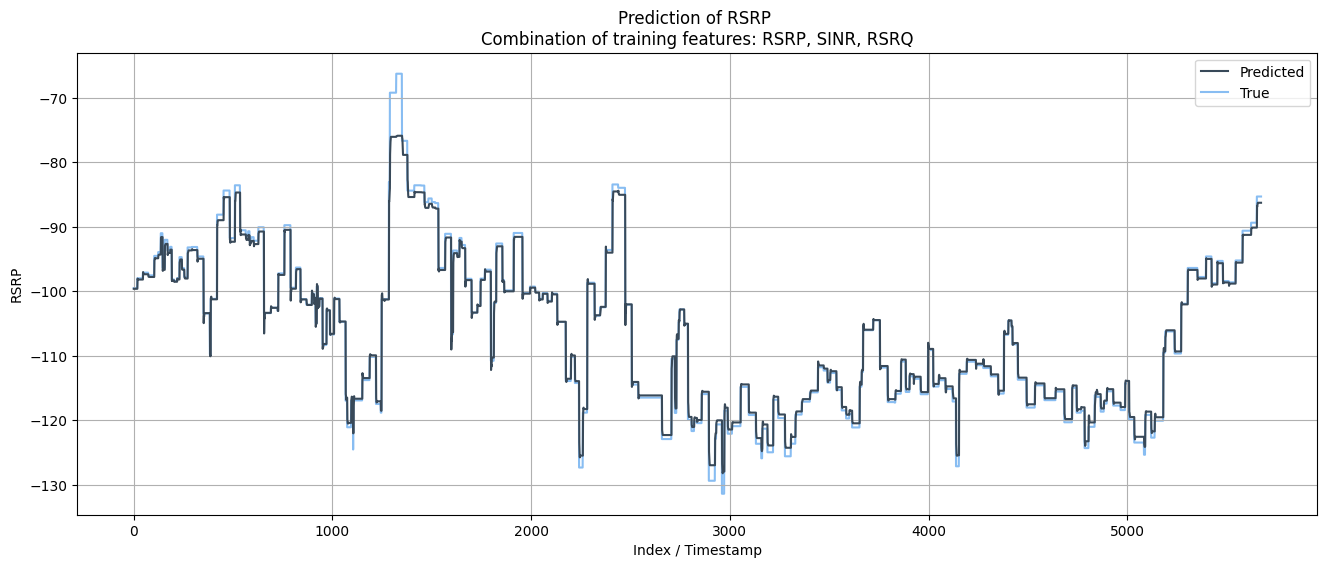

In [23]:
selected_rsrp_comb = 'RSRP, SINR, RSRQ -> RSRP'
rsrp_comb = results[selected_rsrp_comb]
rsrp_pred = rsrp_comb['y_pred']
rsrp_true = rsrp_comb['y_true']
rsrp_train_pred = rsrp_comb['train_pred']
rsrp_train_true = rsrp_comb['train_true']

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
pred = plt.plot(rsrp_pred, label='Predicted', color=rsrp_colors[0], zorder=2)
true = plt.plot(rsrp_true, label='True', color=rsrp_colors[2], zorder=1)
# ho5g = plt.plot(when_5g_ho, [-95 for _ in range(len(when_5g_ho))], '*', color='black', label='HOs from 4G to 5G')
# ho4g = plt.plot(when_4g_ho, [-95 for _ in range(len(when_4g_ho))], '*', color='red', label='HOs from 5G to 4G')
plt.xlabel('Index / Timestamp')
plt.ylabel('RSRP')
# plt.xlim((0, 200))
plt.title(f'Prediction of RSRP \nCombination of training features: RSRP, SINR, RSRQ')
# plt.legend(handles=[pred[0], true[0], ho5g[0], ho4g[0]])
plt.legend(handles=[pred[0], true[0]])
plt.show()

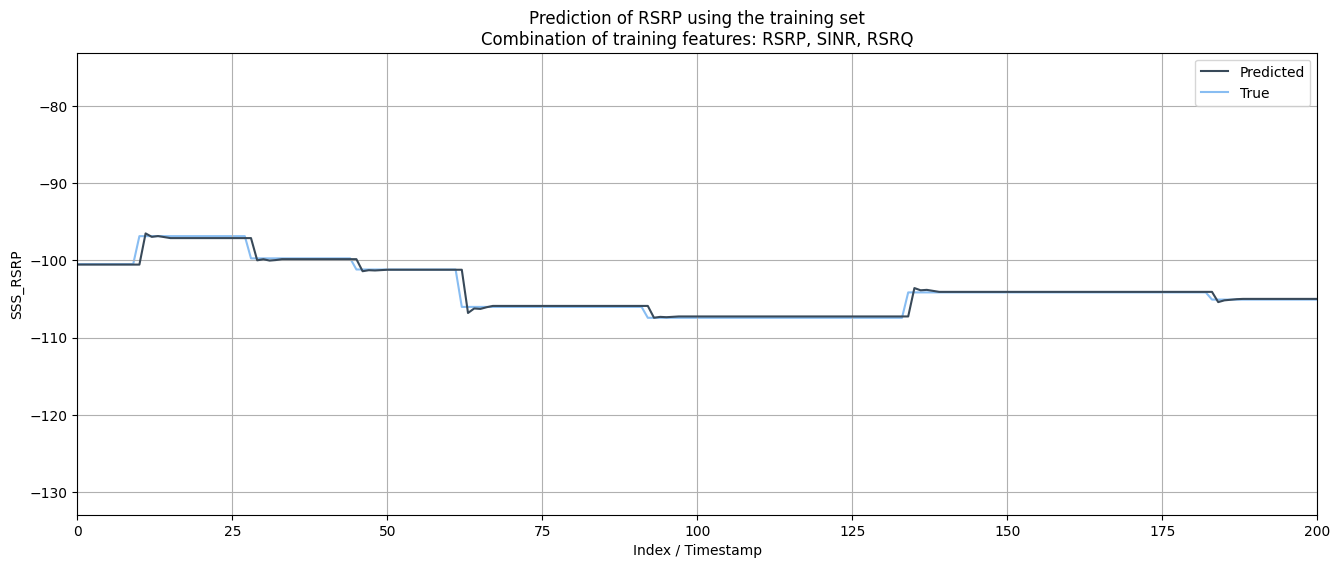

In [24]:
f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
pred = plt.plot(rsrp_train_pred, label='Predicted', color=rsrp_colors[0], zorder=2)
true = plt.plot(rsrp_train_true, label='True', color=rsrp_colors[2], zorder=1)
# ho5g = plt.plot(when_5g_ho, [-95 for _ in range(len(when_5g_ho))], '*', color='black', label='HOs from 4G to 5G')
# ho4g = plt.plot(when_4g_ho, [-95 for _ in range(len(when_4g_ho))], '*', color='red', label='HOs from 5G to 4G')
plt.xlabel('Index / Timestamp')
plt.xlim((0, 200))
plt.ylabel('SSS_RSRP')
plt.title(f'Prediction of RSRP using the training set\nCombination of training features: RSRP, SINR, RSRQ')
# plt.legend(handles=[pred[0], true[0], ho5g[0], ho4g[0]])
plt.legend(handles=[pred[0], true[0]])
plt.show()

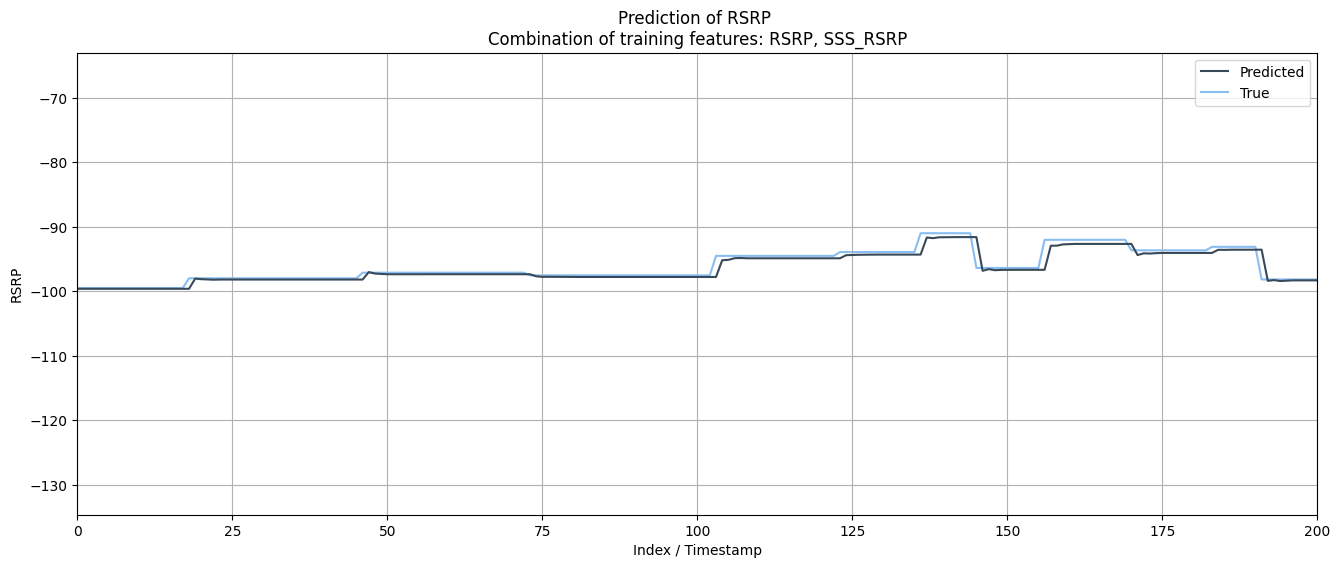

In [25]:
selected_rsrp_sss_comb = 'RSRP, SSS_RSRP -> RSRP'
rsrp_sss_comb = results[selected_rsrp_sss_comb]
rsrp_sss_pred = rsrp_comb['y_pred']
rsrp_sss_true = rsrp_comb['y_true']

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
pred = plt.plot(rsrp_sss_pred, label='Predicted', color=rsrp_colors[0], zorder=2)
true = plt.plot(rsrp_sss_true, label='True', color=rsrp_colors[2], zorder=1)
# ho5g = plt.plot(when_5g_ho, [-95 for _ in range(len(when_5g_ho))], '*', color='black', label='HOs from 4G to 5G')
# ho4g = plt.plot(when_4g_ho, [-95 for _ in range(len(when_4g_ho))], '*', color='red', label='HOs from 5G to 4G')
plt.xlabel('Index / Timestamp')
plt.ylabel('RSRP')
plt.xlim((0, 200))
plt.title(f'Prediction of RSRP \nCombination of training features: RSRP, SSS_RSRP')
# plt.legend(handles=[pred[0], true[0], ho5g[0], ho4g[0]])
plt.legend(handles=[pred[0], true[0]])
plt.show()

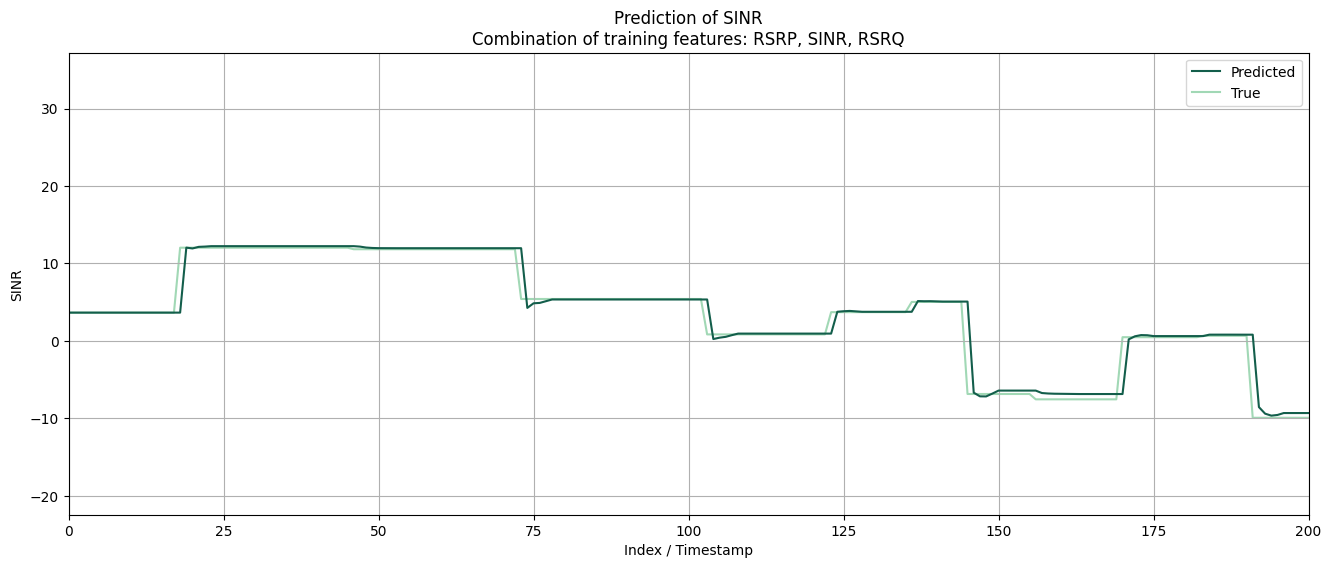

In [26]:
selected_sinr_comb = 'RSRP, SINR, RSRQ -> SINR'
sinr_comb = results[selected_sinr_comb]
sinr_pred = sinr_comb['y_pred']
sinr_true = sinr_comb['y_true']

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
pred = plt.plot(sinr_pred, label='Predicted', color=sinr_colors[0], zorder=2)
true = plt.plot(sinr_true, label='True', color=sinr_colors[2], zorder=1)
# ho5g = plt.plot(when_5g_ho, [0 for _ in range(len(when_5g_ho))], '*', color='black', label='HOs from 4G to 5G')
# ho4g = plt.plot(when_4g_ho, [0 for _ in range(len(when_4g_ho))], '*', color='red', label='HOs from 5G to 4G')
plt.xlabel('Index / Timestamp')
plt.ylabel('SINR')
plt.title(f'Prediction of SINR\nCombination of training features: RSRP, SINR, RSRQ')
plt.xlim((0, 200))
# plt.legend(handles=[pred[0], true[0], ho5g[0], ho4g[0]])
plt.legend(handles=[pred[0], true[0]])
plt.show()

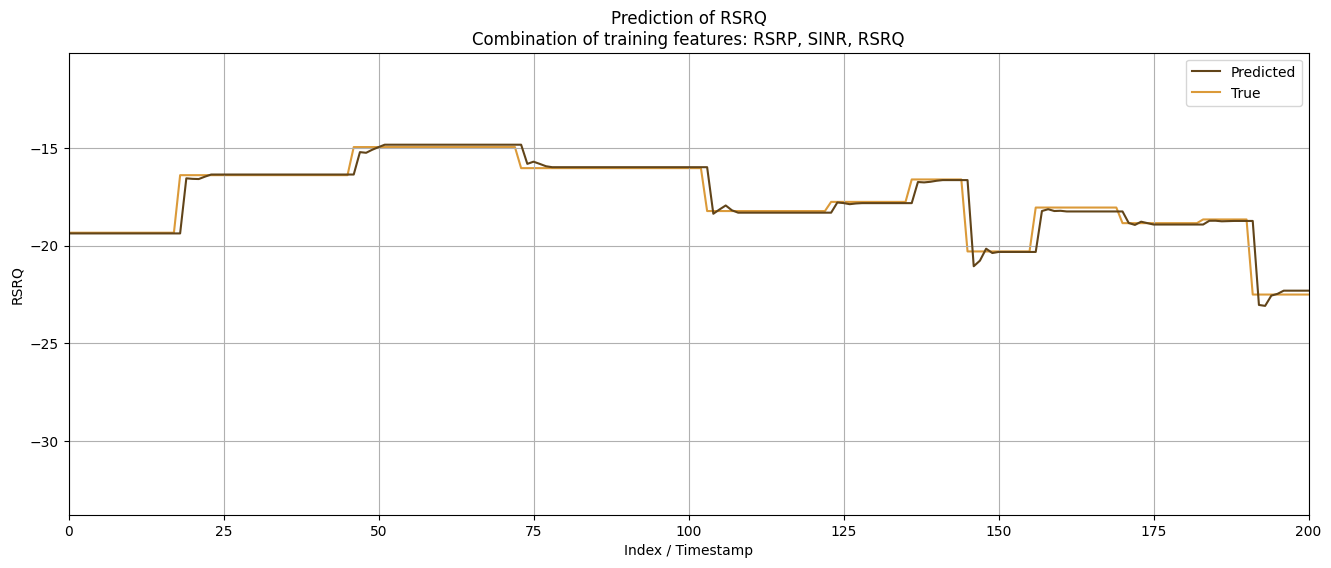

In [27]:
selected_rsrq_comb = 'RSRP, SINR, RSRQ -> RSRQ'
rsrq_comb = results[selected_rsrq_comb]
rsrq_pred = rsrq_comb['y_pred']
rsrq_true = rsrq_comb['y_true']

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
pred = plt.plot(rsrq_pred, label='Predicted', color=rsrq_colors[0], zorder=2)
true = plt.plot(rsrq_true, label='True', color=rsrq_colors[2], zorder=1)
# ho5g = plt.plot(when_5g_ho, [-25 for _ in range(len(when_5g_ho))], '*', color='black', label='HOs from 4G to 5G')
# ho4g = plt.plot(when_4g_ho, [-25 for _ in range(len(when_4g_ho))], '*', color='red', label='HOs from 5G to 4G')
plt.xlabel('Index / Timestamp')
plt.ylabel('RSRQ')
plt.xlim((0, 200))
plt.title(f'Prediction of RSRQ\nCombination of training features: RSRP, SINR, RSRQ')
# plt.legend(handles=[pred[0], true[0], ho5g[0], ho4g[0]])
plt.legend(handles=[pred[0], true[0]])
plt.show()

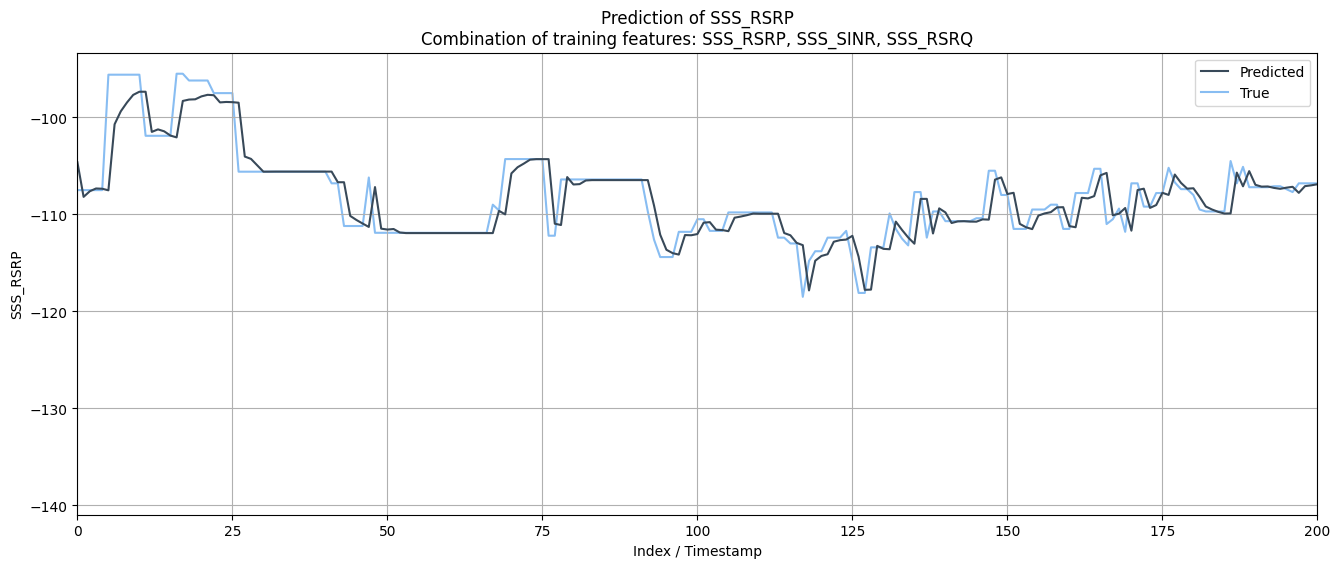

In [28]:
selected_sss_rsrp_comb = 'SSS_RSRP, SSS_SINR, SSS_RSRQ -> SSS_RSRP'
sss_rsrp_comb = results[selected_sss_rsrp_comb]
sss_rsrp_pred = sss_rsrp_comb['y_pred']
sss_rsrp_true = sss_rsrp_comb['y_true']
sss_rsrp_train_pred = sss_rsrp_comb['train_pred']
sss_rsrp_train_true = sss_rsrp_comb['train_true']

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
pred = plt.plot(sss_rsrp_pred, label='Predicted', color=rsrp_colors[0], zorder=2)
true = plt.plot(sss_rsrp_true, label='True', color=rsrp_colors[2], zorder=1)
# ho5g = plt.plot(when_5g_ho, [-95 for _ in range(len(when_5g_ho))], '*', color='black', label='HOs from 4G to 5G')
# ho4g = plt.plot(when_4g_ho, [-95 for _ in range(len(when_4g_ho))], '*', color='red', label='HOs from 5G to 4G')
plt.xlabel('Index / Timestamp')
plt.ylabel('SSS_RSRP')
plt.xlim((0, 200))
plt.title(f'Prediction of SSS_RSRP\nCombination of training features: SSS_RSRP, SSS_SINR, SSS_RSRQ')
# plt.legend(handles=[pred[0], true[0], ho5g[0], ho4g[0]])
plt.legend(handles=[pred[0], true[0]])
plt.show()

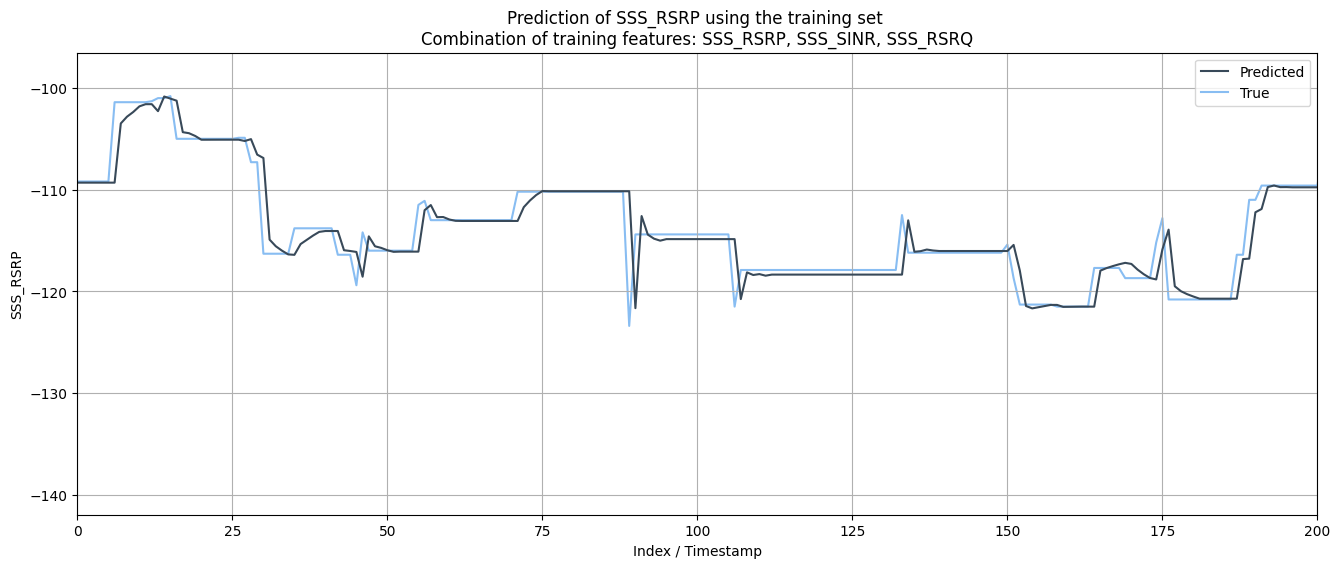

In [29]:
f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
pred = plt.plot(sss_rsrp_train_pred, label='Predicted', color=rsrp_colors[0], zorder=2)
true = plt.plot(sss_rsrp_train_true, label='True', color=rsrp_colors[2], zorder=1)
# ho5g = plt.plot(when_5g_ho, [-95 for _ in range(len(when_5g_ho))], '*', color='black', label='HOs from 4G to 5G')
# ho4g = plt.plot(when_4g_ho, [-95 for _ in range(len(when_4g_ho))], '*', color='red', label='HOs from 5G to 4G')
plt.xlabel('Index / Timestamp')
plt.xlim((0, 200))
plt.ylabel('SSS_RSRP')
plt.title(f'Prediction of SSS_RSRP using the training set \nCombination of training features: SSS_RSRP, SSS_SINR, SSS_RSRQ')
# plt.legend(handles=[pred[0], true[0], ho5g[0], ho4g[0]])
plt.legend(handles=[pred[0], true[0]])
plt.show()

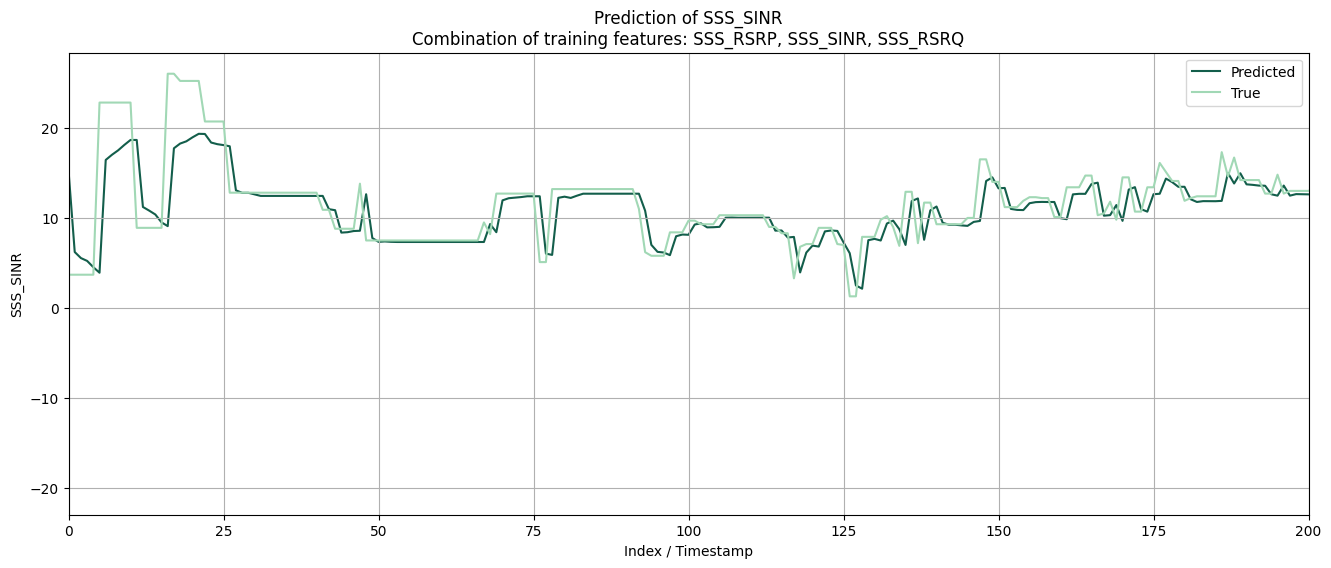

In [30]:
selected_sss_sinr_comb = 'SSS_RSRP, SSS_SINR, SSS_RSRQ -> SSS_SINR'
sss_sinr_comb = results[selected_sss_sinr_comb]
sss_sinr_pred = sss_sinr_comb['y_pred']
sss_sinr_true = sss_sinr_comb['y_true']

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
pred = plt.plot(sss_sinr_pred, label='Predicted', color=sinr_colors[0], zorder=1)
true = plt.plot(sss_sinr_true, label='True', color=sinr_colors[2], zorder=2)
# ho5g = plt.plot(when_5g_ho, [0 for _ in range(len(when_5g_ho))], '*', color='black', label='HOs from 4G to 5G')
# ho4g = plt.plot(when_4g_ho, [0 for _ in range(len(when_4g_ho))], '*', color='red', label='HOs from 5G to 4G')
plt.xlabel('Index / Timestamp')
plt.ylabel('SSS_SINR')
plt.xlim((0, 200))
plt.title(f'Prediction of SSS_SINR\nCombination of training features: SSS_RSRP, SSS_SINR, SSS_RSRQ')
# plt.legend(handles=[pred[0], true[0], ho5g[0], ho4g[0]])
plt.legend(handles=[pred[0], true[0]])
plt.show()

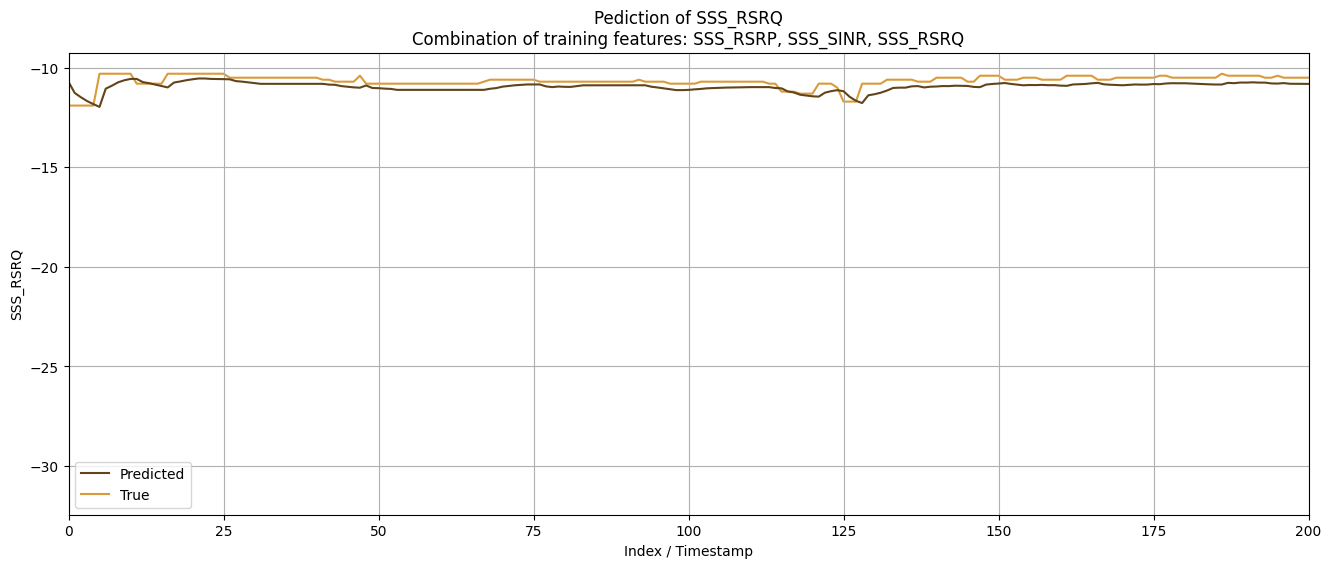

In [31]:
selected_sss_rsrq_comb = 'SSS_RSRP, SSS_SINR, SSS_RSRQ -> SSS_RSRQ'
sss_rsrq_comb = results[selected_sss_rsrq_comb]
sss_rsrq_pred = sss_rsrq_comb['y_pred']
sss_rsrq_true = sss_rsrq_comb['y_true']

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
pred = plt.plot(sss_rsrq_pred, label='Predicted', color=rsrq_colors[0], zorder=2)
true = plt.plot(sss_rsrq_true, label='True', color=rsrq_colors[2], zorder=1)
# ho5g = plt.plot(when_5g_ho, [-25 for _ in range(len(when_5g_ho))], '*', color='black', label='HOs from 4G to 5G')
# ho4g = plt.plot(when_4g_ho, [-25 for _ in range(len(when_4g_ho))], '*', color='red', label='HOs from 5G to 4G')
plt.xlabel('Index / Timestamp')
plt.ylabel('SSS_RSRQ')
plt.xlim((0, 200))
plt.title(f'Pediction of SSS_RSRQ\nCombination of training features: SSS_RSRP, SSS_SINR, SSS_RSRQ')
# plt.legend(handles=[pred[0], true[0], ho5g[0], ho4g[0]])
plt.legend(handles=[pred[0], true[0]])
plt.show()

In [32]:
preds = pd.DataFrame({'RSRP' : [x[0] for x in rsrp_pred],
                      'SINR' : [x[0] for x in sinr_pred],
                      'RSRQ' : [x[0] for x in rsrq_pred]},
                      columns=['RSRP', 'SINR', 'RSRQ'])

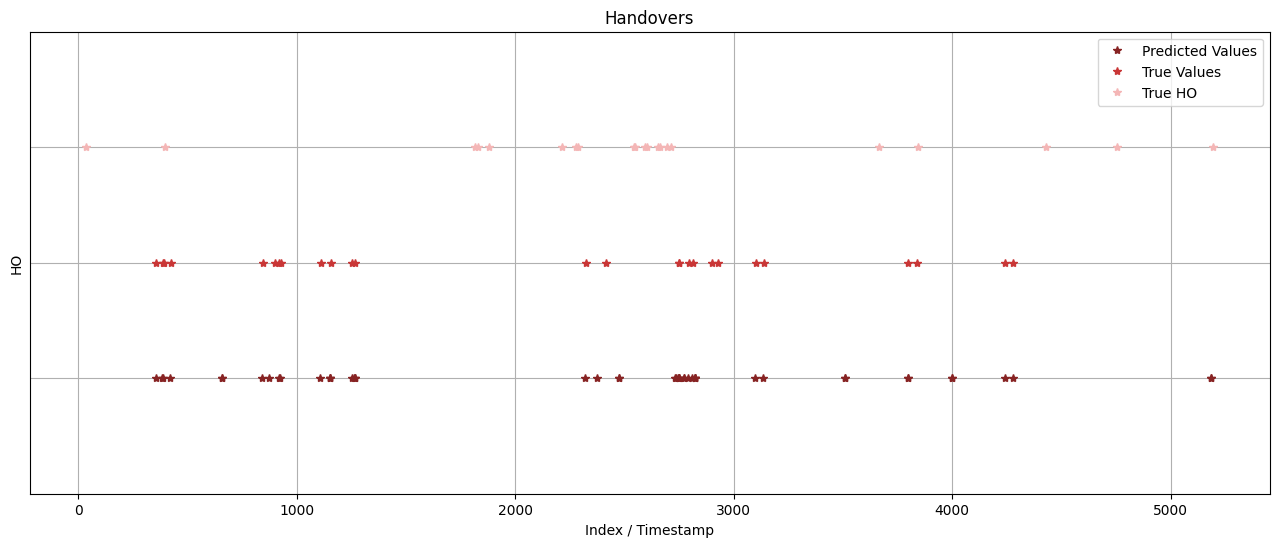

In [33]:
selected_rf_comb = 'RSRP, SINR, RSRQ'
rf_comb = rf_results[selected_rf_comb]
rf_model = rf_comb['model']
rf_pred_true = rf_comb['y_pred']

rf_pred = rf_model.predict(preds)

ho_pred_true = check_handover_array(rf_pred_true, 'both')
ho_pred = check_handover_array(rf_pred, 'both')
ho_true = check_handover(mode_test, 'both')

when_pred_true_ho = []
when_pred_ho = []
when_true_ho = []

for i in range(len(ho_pred)):
    if ho_pred_true[i] == 1:
        when_pred_true_ho.append(i)
    if ho_pred[i] == 1:
        when_pred_ho.append(i)
    if ho_true[i] == 1:
        when_true_ho.append(i)

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
plt.plot(when_pred_ho, [1 for _ in range(len(when_pred_ho))], '*', color=mode_colors[0], label='Predicted Values', zorder=4)
plt.plot(when_pred_true_ho, [1.5 for _ in range(len(when_pred_true_ho))], '*', color=mode_colors[1], label='True Values', zorder=2)
plt.plot(when_true_ho, [2 for _ in range(len(when_true_ho))], '*', color=mode_colors[3], label='True HO', zorder=3)
plt.xlabel('Index / Timestamp')
plt.ylabel('HO')
plt.ylim((0.5, 2.5))
plt.yticks([1, 1.5, 2])
plt.tick_params(left = False, labelleft = False)
plt.title(f'Handovers')
plt.legend()
plt.show()